## Choosing a classification algorithm

- No free lunch theorem: no single algorithm works best across all possible scenarios.
- Its always recommended you compare the performance of different algorithms (or try ensemble models).

### Main steps involved in training a supervised machine learning algorithm

- Selecting features and collecting labeled training examples.
- Choosing a performance metric.
- Choosing a learning algorithm and training a model.
- Evaluating the performance of the model.
- Changing the setting of the algorithm and tuning the model.

### First steps scikit-learn training a perceptron



In [ ]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print("Class labels:", np.unique(y))

In [2]:
# separate the test into training and testing
# automatically shuffles the data
# stratify makes sure we have the same proportion of class labels as the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [3]:
# making sure the dataset is balanced
print(f"Labels count in y: {np.bincount(y)}")
print(f"Labels count in y_train: {np.bincount(y_train)}")
print(f"Labels count in y_test: {np.bincount(y_test)}")

Labels count in y: [50 50 50]
Labels count in y_train: [35 35 35]
Labels count in y_test: [15 15 15]


In [4]:
# many algorithms require feature scaling
# we will apply standarization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # initialize a new StandardScaler object
sc.fit(X_train)       # Estimate the mean and standard deviation of the training dataset
X_train_std = sc.transform(X_train) # Standardize training and testing data
X_test_std = sc.transform(X_test)

In [5]:
# now we can train a perceptron
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=1) # initialize a new object from the Perceptron class
ppn.fit(X_train_std, y_train) # train our perceptron

Perceptron(eta0=0.1, random_state=1)

In [6]:
# we can make predictions with a trained model using the predict method
y_pred = ppn.predict(X_test_std)
print(f"Misclassified examples: {(y_test != y_pred).sum()}")

Misclassified examples: 1


The classification error is:
$$
error = \frac{1}{45} \approx 0.022
$$

Instead, we can present the accuracy:
$$
1 - error = 0.978
$$

In [7]:
# scikit learn implements a variety of performance metrics on the metrics module
from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Accuracy: 0.978


In [8]:
# each classifier in scikit learn has a score method
print(f"Accuracy:  {ppn.score(X_test_std, y_test):.3f}")

Accuracy:  0.978


Now, lets create function that plots the decision regions

In [29]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ("o", "s", "^", "v", "<")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f"Class {cl}",
                    edgecolor="black")
    # highlight test examples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c="none", edgecolor="black", alpha=1.0,
                    linewidth=1, marker="o",
                    s=100, label="Test set")

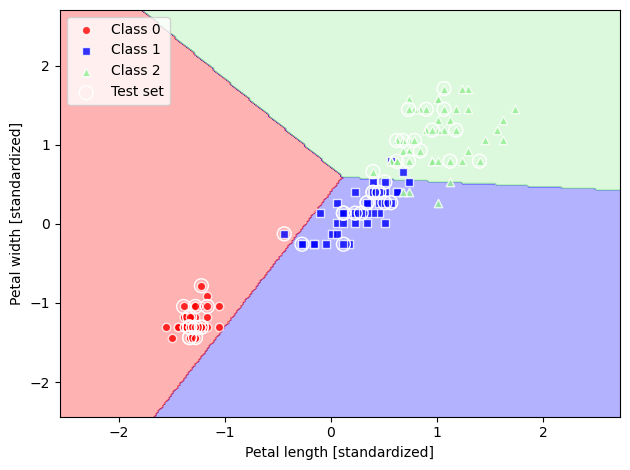

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
help(Perceptron)

Help on class Perceptron in module sklearn.linear_model._perceptron:

class Perceptron(sklearn.linear_model._stochastic_gradient.BaseSGDClassifier)
 |  Perceptron(*, penalty=None, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, eta0=1.0, n_jobs=None, random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False)
 |
 |  Linear perceptron classifier.
 |
 |  The implementation is a wrapper around :class:`~sklearn.linear_model.SGDClassifier`
 |  by fixing the `loss` and `learning_rate` parameters as::
 |
 |      SGDClassifier(loss="perceptron", learning_rate="constant")
 |
 |  Other available parameters are described below and are forwarded to
 |  :class:`~sklearn.linear_model.SGDClassifier`.
 |
 |  Read more in the :ref:`User Guide <perceptron>`.
 |
 |  Parameters
 |  ----------
 |
 |  penalty : {'l2','l1','elasticnet'}, default=None
 |      The penalty (aka regularization term) to

## Modelling probabilities via logistic regression

- The perceptron only converges if the classes are linearly separable.
- A more powerful algorithm is called **logistic regression**.

### Logistic regression and conditional probabilities

- It can be generalized to multiclass settings, known as **multinomial logistic regression** or **softmax regression**.

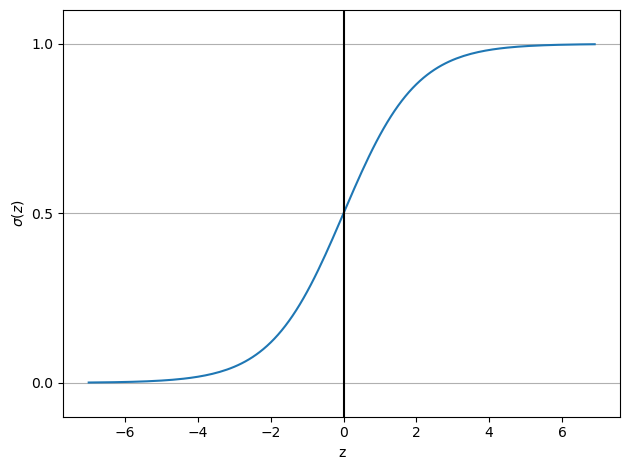

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.axvline(0.0, color="k")
plt.ylim(-0.1, 1.1)
plt.xlabel("z")
plt.ylabel(r"$\sigma (z)$")
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

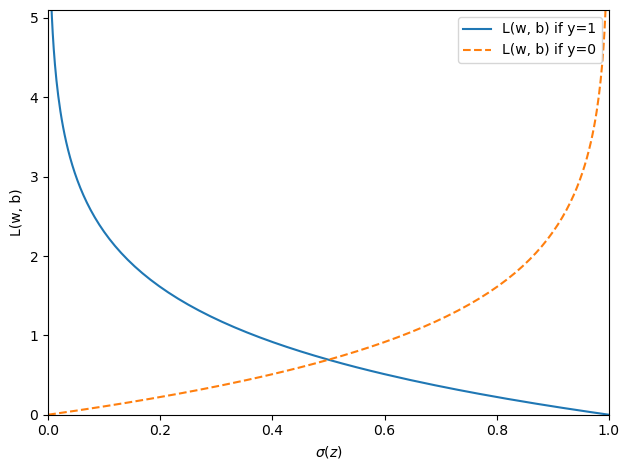

In [17]:
def loss_1(z):
    return - np.log(sigmoid(z))
def loss_0(z):
    return - np.log(1 - sigmoid(z))
z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel(r'$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Converting an Adaline implementation into an algorithm for logistic regression

- By substituting the loss function, L, in our Adaline implementation we get our logistic regression.

In [22]:
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.
    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight
        initialization.

    Attributes
    -----------
    w_ : 1d-array
        Weights after training.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
        Mean squared error loss function values in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the
            number of examples and n_features is the
            number of features.
        y : array-like, shape = [n_examples]
            Target values.

        Returns
        -------
        self : Instance of LogisticRegressionGD
        """

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (-y.dot(np.log(output))
                    - ((1 - y).dot(np.log(1 - output)))
                    / X.shape[0])
            self.losses_.append(loss)

        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

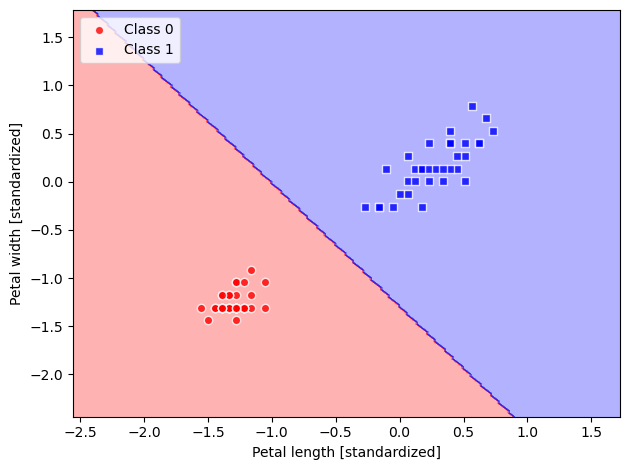

In [23]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.3,
                            n_iter=1000,
                            random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Training a logistic regression model with scikit learn

- Can be used for multiclass classification.
- We use the "ovr" method for this example.
- "multinomial" setting is best used for mutually exclusive classes.

C:\Users\Mateo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


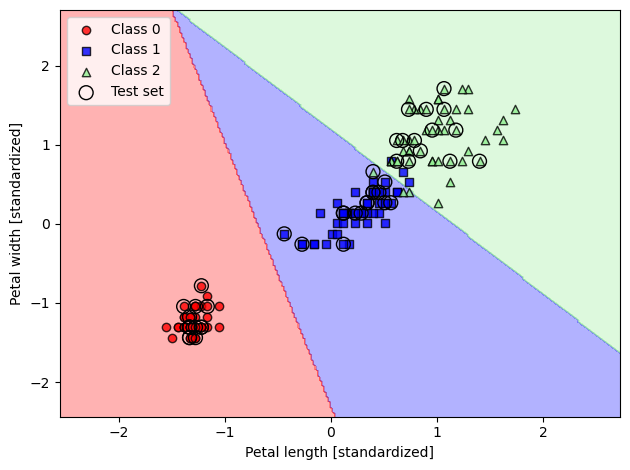

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, solver="lbfgs",
                        multi_class="ovr")
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=lr,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\Mateo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


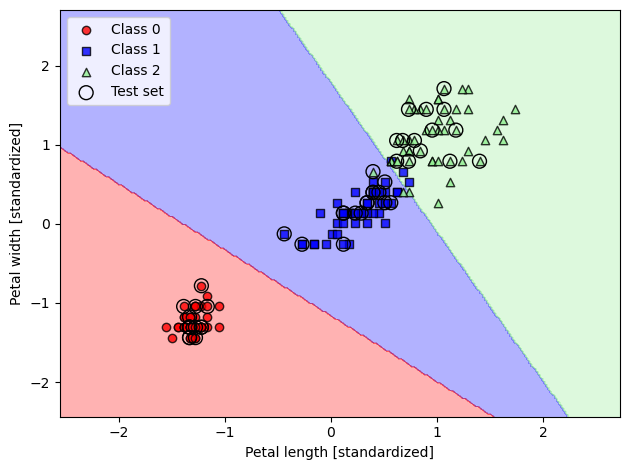

In [31]:
lr = LogisticRegression(C=100.0, solver="lbfgs",
                        multi_class="multinomial")
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=lr,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

- For minimizing the convex loss functions more advanced approaches are recommended.
- `solver` parameter is the optimization algorithm.
- "newton-cg", "lbfgs", "liblinear", "sag", "saga".

- We can find the probability that training examples belong to a certain class

In [32]:
lr.predict_proba(X_test_std[:3, :])

array([[9.37368464e-13, 3.91458193e-04, 9.99608542e-01],
       [9.93631074e-01, 6.36892585e-03, 1.20730798e-15],
       [9.98707332e-01, 1.29266792e-03, 1.82177043e-17]])

In [33]:
# we can find the highest probability of each observation
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

In [34]:
# this is how we make predictions
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [35]:
# to predict a single example we have to convert a single row slice into the correct format first
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

In [38]:
X_test_std[0, :].reshape(1, -1)

array([[0.89820289, 1.44587881]])

In [39]:
X_test_std[0, :]

array([0.89820289, 1.44587881])

### Tackling overfitting via regularization


C:\Users\Mateo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Mateo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Mateo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Mateo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_clas

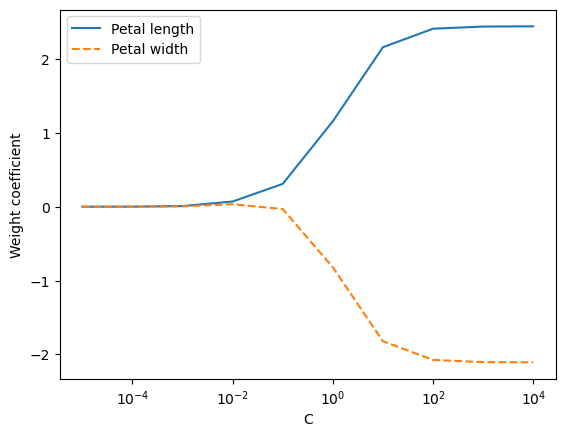

In [40]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c,
                            multi_class="ovr")
    lr.fit(X_train_std, y_train)
    weights.append((lr.coef_[1]))
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label="Petal length")
plt.plot(params, weights[:, 1], linestyle="--",
         label="Petal width")
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()